## Import Libraries and Datasets

In [47]:
# Import Packages
import os
import scipy
from scipy.cluster.hierarchy import dendrogram, linkage
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from scipy import stats
from sklearn.manifold import TSNE
import plotly.offline as pyoff


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

sns.set()
%matplotlib inline

In [48]:
# read and check the dataset
df= pd.read_csv("data_agg.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9131 entries, 0 to 9130
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Unnamed: 0                             9131 non-null   int64  
 1   user_id                                9131 non-null   object 
 2   city                                   9131 non-null   object 
 3   state                                  9131 non-null   object 
 4   zip                                    9131 non-null   object 
 5   age                                    9131 non-null   float64
 6   journal_entry_created_at               9131 non-null   int64  
 7   user_registered_at                     9131 non-null   int64  
 8   transaction_number                     9131 non-null   int64  
 9   entry_slip_fee                         9131 non-null   float64
 10  entry_slip_payout                      9131 non-null   float64
 11  entr

## Preprocessing

In [49]:
# convert age to numeric value
df['age'] = df['age'].astype('int')
df.head()

,Unnamed: 0,user_id,city,state,zip,age,journal_entry_created_at,user_registered_at,transaction_number,entry_slip_fee,entry_slip_payout,entry_slip_boost_payout,"('balance_difference', 'BoostPayout')","('balance_difference', 'Deposit')","('balance_difference', 'Withdrawal')"
0,0,0003f859b9840eb2adaf4052d570db45,BRYAN,TX,77808,19,2,171,26,57.0,187.0,0.0,0.0,0.0,0.0
1,1,0007f8f65aaf99ef992bae1942b12ca3,LOS ANGELES,CA,90034,61,1,85,6,14.0,0.0,0.0,0.0,0.0,0.0
2,2,00216f72610fb717007112f7ce9b8079,GARDENA,CA,90249,26,1,186,41,70.0,10.0,0.0,0.0,60.0,0.0
3,3,0027f6b18c850f235db0a32e67b8b545,BROOKLYN,NY,11223,32,3,3,3,20.0,0.0,0.0,0.0,200.0,0.0
4,4,00283074ece4e2fe1167613dd471a961,BOSTON,MA,02116,29,6,7,25,200.0,105.0,0.0,0.0,200.0,-105.0


In [50]:
# drop unuseful columns
df_x = df.drop(columns = ['Unnamed: 0', 'user_id', 'city', 'state', 'zip'])

In [51]:
df_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9131 entries, 0 to 9130
Data columns (total 10 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   age                                    9131 non-null   int64  
 1   journal_entry_created_at               9131 non-null   int64  
 2   user_registered_at                     9131 non-null   int64  
 3   transaction_number                     9131 non-null   int64  
 4   entry_slip_fee                         9131 non-null   float64
 5   entry_slip_payout                      9131 non-null   float64
 6   entry_slip_boost_payout                9131 non-null   float64
 7   ('balance_difference', 'BoostPayout')  9131 non-null   float64
 8   ('balance_difference', 'Deposit')      9131 non-null   float64
 9   ('balance_difference', 'Withdrawal')   9131 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 713.5 KB


In [52]:
# rename coulumns
df_x.columns=['age','time_from_last_activity','time_from_register','transaction_max','total_fee','total_payout','total_boost_payout','cum_BoostPayout','cum_Deposit','cum_Withdrawal']
df_x['cum_Withdrawal'] = df_x['cum_Withdrawal'].abs()

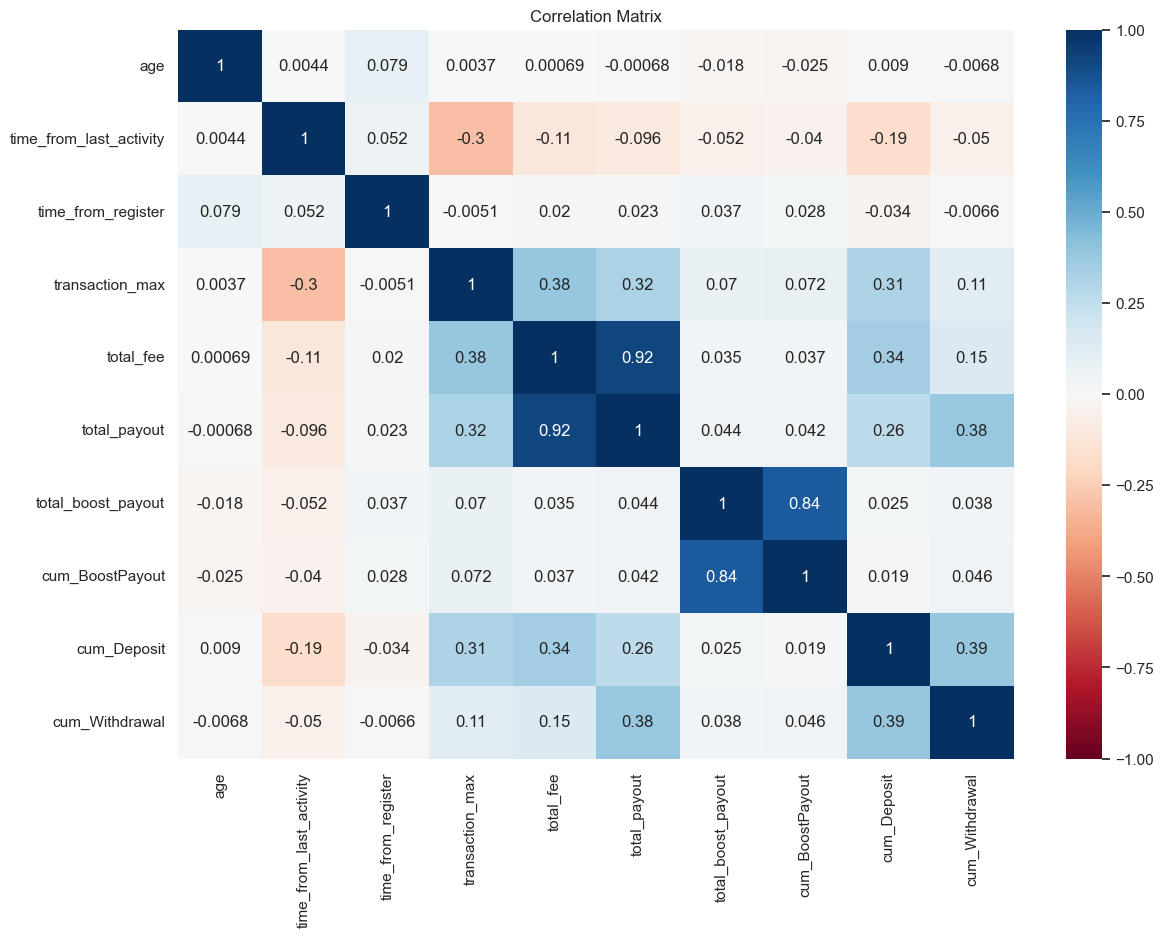

In [53]:
# check correlation between features
plt.figure(figsize=(12, 9))
s = sns.heatmap(df_x.corr(),
                annot=True,
                cmap='RdBu',
                vmin=-1,
                vmax=1)
s.set_xticklabels(s.get_xticklabels(), rotation=90)
plt.title('Correlation Matrix')
plt.show()

In [54]:
# Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

age's: Skew: 1.1222245385972613, : SkewtestResult(statistic=35.81265146706704, pvalue=7.018417875986158e-281)
time_from_last_activity's: Skew: 0.5592020366725783, : SkewtestResult(statistic=20.412507340626107, pvalue=1.2946956824339878e-92)
time_from_register's: Skew: 1.324242203575407, : SkewtestResult(statistic=40.198906290829306, pvalue=0.0)
transaction_max's: Skew: 15.719308304635017, : SkewtestResult(statistic=116.50557849023292, pvalue=0.0)
total_fee's: Skew: 48.168020080334564, : SkewtestResult(statistic=152.2276709972297, pvalue=0.0)
total_payout's: Skew: 38.70638013196678, : SkewtestResult(statistic=145.2488735026482, pvalue=0.0)
total_boost_payout's: Skew: 18.53270102487092, : SkewtestResult(statistic=121.7546491352861, pvalue=0.0)
cum_BoostPayout's: Skew: 19.199616343110364, : SkewtestResult(statistic=122.88198488413447, pvalue=0.0)
cum_Deposit's: Skew: 7.956891614217545, : SkewtestResult(statistic=94.83686653462257, pvalue=0.0)
cum_Withdrawal's: Skew: 46.185119023034645, : 

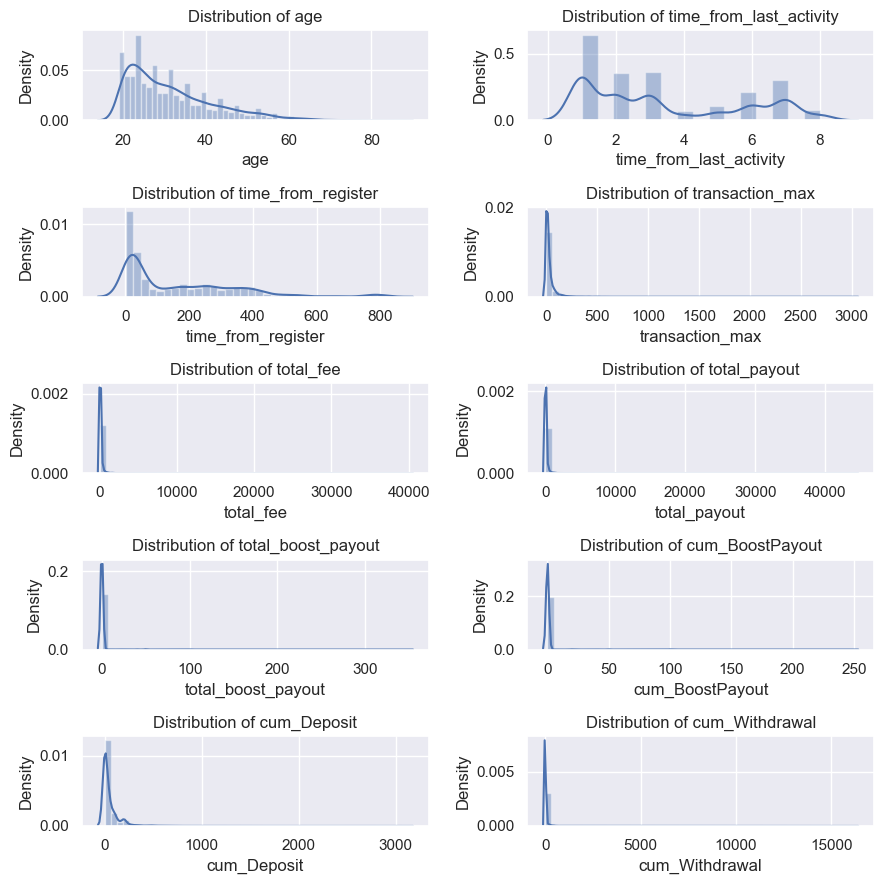

In [55]:
# Plot to check skewness
plt.figure(figsize=(9, 9))
plt.subplot(5, 2, 1)
check_skew(df_x,'age')
plt.subplot(5, 2, 2)
check_skew(df_x,'time_from_last_activity')
plt.subplot(5, 2, 3)
check_skew(df_x,'time_from_register')
plt.subplot(5, 2, 4)
check_skew(df_x,'transaction_max')
plt.subplot(5, 2, 5)
check_skew(df_x,'total_fee')
plt.subplot(5, 2, 6)
check_skew(df_x,'total_payout')
plt.subplot(5, 2, 7)
check_skew(df_x,'total_boost_payout')
plt.subplot(5, 2, 8)
check_skew(df_x,'cum_BoostPayout')
plt.subplot(5, 2, 9)
check_skew(df_x,'cum_Deposit')
plt.subplot(5, 2, 10)
check_skew(df_x,'cum_Withdrawal')
plt.tight_layout()

age's: Skew: 0.5304521609544843, : SkewtestResult(statistic=19.478465068603477, pvalue=1.6721792615936531e-84)
time_from_last_activity's: Skew: 0.14507217817874304, : SkewtestResult(statistic=5.63468972250634, pvalue=1.753737975654818e-08)
time_from_register's: Skew: -0.334061869581891, : SkewtestResult(statistic=-12.704517006317806, pvalue=5.581295151625405e-37)
transaction_max's: Skew: 0.188777634025455, : SkewtestResult(statistic=7.306401849495328, pvalue=2.743907626947064e-13)
total_fee's: Skew: 0.3821374208911142, : SkewtestResult(statistic=14.42369269373706, pvalue=3.6716094626396896e-47)
total_payout's: Skew: 0.8707710093173109, : SkewtestResult(statistic=29.578127677683987, pvalue=2.856374320587559e-192)
total_boost_payout's: Skew: 8.289302264099407, : SkewtestResult(statistic=96.13659469807124, pvalue=0.0)
cum_BoostPayout's: Skew: 9.710674887219614, : SkewtestResult(statistic=101.16692729469148, pvalue=0.0)
cum_Deposit's: Skew: 0.10190052704917583, : SkewtestResult(statistic=3

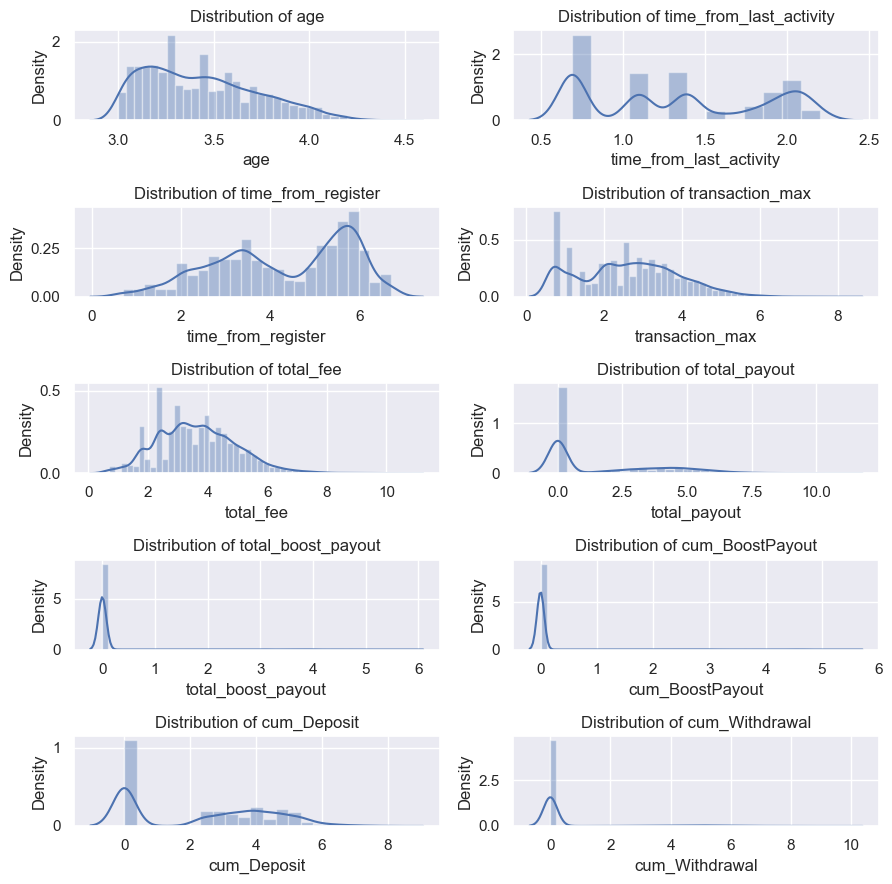

In [56]:
#Removing Skewness
df_x_log = np.log(df_x+1)
plt.figure(figsize=(9, 9))
plt.subplot(5, 2, 1)
check_skew(df_x_log,'age')
plt.subplot(5, 2, 2)
check_skew(df_x_log,'time_from_last_activity')
plt.subplot(5, 2, 3)
check_skew(df_x_log,'time_from_register')
plt.subplot(5, 2, 4)
check_skew(df_x_log,'transaction_max')
plt.subplot(5, 2, 5)
check_skew(df_x_log,'total_fee')
plt.subplot(5, 2, 6)
check_skew(df_x_log,'total_payout')
plt.subplot(5, 2, 7)
check_skew(df_x_log,'total_boost_payout')
plt.subplot(5, 2, 8)
check_skew(df_x_log,'cum_BoostPayout')
plt.subplot(5, 2, 9)
check_skew(df_x_log,'cum_Deposit')
plt.subplot(5, 2, 10)
check_skew(df_x_log,'cum_Withdrawal')
plt.tight_layout()

In [57]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaler.fit(df_x_log)
df_x_scaled = scaler.transform(df_x_log)

## Modeling: Unsupervised Learing-K means

In [58]:
# build several k means models to generate the elbow method plot
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(df_x_scaled) 
    kmeanModel.fit(df_x_scaled)     
      
    distortions.append(sum(np.min(cdist(df_x_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / df_x_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(df_x_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / df_x_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_

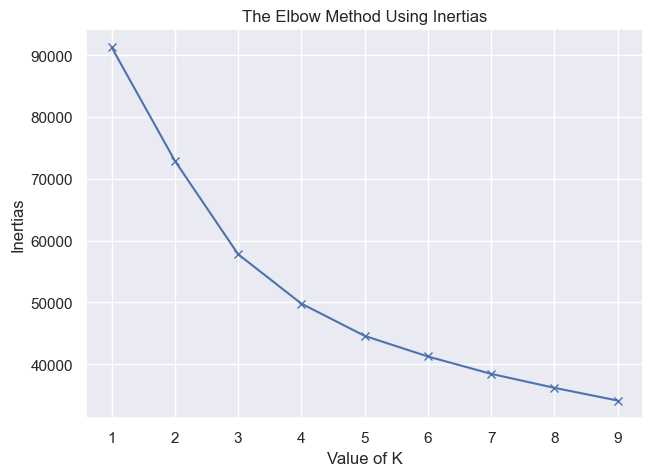

In [59]:
# plot the Elbow method
plt.plot(K, inertias, 'bx-')
plt.xlabel('Value of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method Using Inertias')
plt.show()

In [60]:
# basedon the elbow method, choose 4 clusters

model = KMeans(n_clusters=4, random_state=42) 

# fit the normalized table

model.fit(df_x_scaled) 
model.labels_.shape

(9131,)

In [61]:
# now add the cluster number to the original table

df_x["cluster"] = model.labels_

df_x = df_x.sort_values(by=['cluster'])
df_x.head(15)

,age,time_from_last_activity,time_from_register,transaction_max,total_fee,total_payout,total_boost_payout,cum_BoostPayout,cum_Deposit,cum_Withdrawal,cluster
7249,20,2,135,57,109.0,150.0,0.0,0.0,89.0,130.0,0
8579,24,2,267,166,485.0,565.0,0.0,0.0,340.0,280.0,0
5719,30,3,68,22,50.0,25.0,0.0,0.0,50.0,25.0,0
2552,29,1,233,83,96.0,308.5,0.0,0.0,101.0,195.0,0
654,31,2,190,43,155.0,250.0,0.0,0.0,10.0,105.0,0
8058,19,7,14,17,50.0,60.0,0.0,0.0,50.0,60.0,0
2025,40,2,20,41,120.0,220.0,0.0,0.0,80.0,180.0,0
3618,22,1,21,504,163.0,272.0,0.0,0.0,95.0,180.0,0
8059,28,1,118,158,177.0,152.5,0.0,0.0,10.0,130.0,0
8848,31,1,7,106,167.0,250.0,0.0,0.0,152.0,230.0,0


In [62]:
# Cluster analysis
avg_df_x = df_x.groupby(['cluster'], as_index=False).mean()
avg_df_x

,cluster,age,time_from_last_activity,time_from_register,transaction_max,total_fee,total_payout,total_boost_payout,cum_BoostPayout,cum_Deposit,cum_Withdrawal
0,0,29.551821,2.355742,148.547619,76.292717,272.816527,434.827731,0.194678,0.007003,150.998599,294.565028
1,1,31.971076,4.890135,189.794395,7.147982,22.646413,4.242377,0.019955,0.000673,16.292601,0.567823
2,2,29.297521,2.438017,239.165289,66.826446,237.876033,312.322314,61.363636,45.743802,69.190083,73.337686
3,3,31.281804,1.927789,140.134254,47.723931,174.994004,124.599062,0.053962,0.002346,92.490876,0.038900


In [63]:
# see how many users in each cluster
df_x.groupby('cluster').size()

cluster
0     714
1    4460
2     121
3    3836
dtype: int64

In [64]:
# to visualize the result, use PCA to obtain the principal components 
pca = PCA(n_components=3)
principal_comp = pca.fit_transform(df_x_scaled)
principal_comp

array([[ 8.03981440e-01,  1.72825570e-02,  5.10400836e-01],
       [-1.01324166e+00, -2.21386692e-04,  1.47385825e+00],
       [ 1.30326769e+00, -4.96450007e-01, -4.28419351e-02],
       ...,
       [-1.09852793e+00,  2.22167432e-01,  4.86080628e-01],
       [ 8.74710352e-01, -8.02836179e-01, -2.19173715e+00],
       [ 4.02427822e-01, -4.42462274e-01,  3.83985464e-02]])

In [65]:
# Create a dataframe with the three components
pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2','pca3'])
pca_df.head()

,pca1,pca2,pca3
0,0.803981,0.017283,0.510401
1,-1.013242,-0.000221,1.473858
2,1.303268,-0.496450,-0.042842
3,-0.651243,-0.487146,-2.047176
4,2.349453,-0.559865,-0.702021


In [66]:
# Concatenate the clusters labels to the dataframe
labels = model.labels_
pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels})], axis = 1)
pca_df.head()

,pca1,pca2,pca3,cluster
0,0.803981,0.017283,0.510401,3
1,-1.013242,-0.000221,1.473858,1
2,1.303268,-0.496450,-0.042842,3
3,-0.651243,-0.487146,-2.047176,1
4,2.349453,-0.559865,-0.702021,0


In [69]:
# # visualize the result using 3D plot
# import plotly.graph_objects as go

# ClusterPlot = go.Figure() # create the figure

# for C in list(pca_df.cluster.unique()): # add the points according to its cluster
    
#     ClusterPlot.add_trace(go.Scatter3d(x = pca_df[pca_df.cluster == C]['pca1'], # define the values for each variable
#                                 y = pca_df[pca_df.cluster == C]['pca2'],
#                                 z = pca_df[pca_df.cluster == C]['pca3'],
#                                 mode = 'markers', marker_size = 7, marker_line_width = 1,
#                                 name = 'Group ' + str(C)))
    
# ClusterPlot.update_layout(width = 800, height = 800, autosize = True, showlegend = True, # add some format to the table
#                    scene = dict(xaxis=dict(title = 'pca1', titlefont_color = 'black'),
#                                 yaxis=dict(title = 'pca2', titlefont_color = 'black'),
#                                 zaxis=dict(title = 'pca3', titlefont_color = 'black')),
#                    font = dict(family = "Gilroy", color  = 'black', size = 12))

# ClusterPlot.show(renderer="colab")
import plotly.graph_objects as go

ClusterPlot = go.Figure()

for C in list(pca_df.cluster.unique()):
    ClusterPlot.add_trace(go.Scatter3d(x=pca_df[pca_df.cluster==C]['pca1'],
                                       y=pca_df[pca_df.cluster==C]['pca2'],
                                       z=pca_df[pca_df.cluster==C]['pca3'],
                                       mode='markers',
                                       marker_size=7,
                                       marker_line_width=1,
                                       name='Group ' + str(C)))

ClusterPlot.update_layout(width=800,
                          height=800,
                          autosize=True,
                          showlegend=True,
                          scene=dict(xaxis=dict(title='pca1', titlefont_color='black'),
                                     yaxis=dict(title='pca2', titlefont_color='black'),
                                     zaxis=dict(title='pca3', titlefont_color='black')),
                          font=dict(family="Gilroy", color='black', size=12))

ClusterPlot.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Dimension Reduction- Deep Learning Autoencoder(AE)

In [ ]:
# build an Autoencoder

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from keras.optimizers import SGD



input_df = Input(shape=(10,))


# Glorot normal initializer (Xavier normal initializer) draws samples from a truncated normal distribution 

x = Dense(8, activation='relu')(input_df)
x = Dense(6, activation='relu', kernel_initializer = 'glorot_uniform')(x)

encoded = Dense(3, activation='relu', kernel_initializer = 'glorot_uniform', name = 'encode_layer')(x)

x = Dense(6, activation='relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(8, activation='relu', kernel_initializer = 'glorot_uniform')(x)

decoded = Dense(10, kernel_initializer = 'glorot_uniform', name = 'decode_layer')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

#encoder - used for our dimention reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer= 'adam', loss='mean_squared_error')

In [ ]:
# train an Autoencoder
autoencoder.fit(df_x_scaled, df_x_scaled, batch_size = 128, epochs = 25, verbose = 1)

Epoch 1/25
72/72 [==============================] - 1s 2ms/step - loss: 0.9901
Epoch 2/25
72/72 [==============================] - 0s 2ms/step - loss: 0.9357
Epoch 3/25
72/72 [==============================] - 0s 2ms/step - loss: 0.8274
Epoch 4/25
72/72 [==============================] - 0s 2ms/step - loss: 0.7049
Epoch 5/25
72/72 [==============================] - 0s 2ms/step - loss: 0.6295
Epoch 6/25
72/72 [==============================] - 0s 2ms/step - loss: 0.5817
Epoch 7/25
72/72 [==============================] - 0s 2ms/step - loss: 0.5362
Epoch 8/25
72/72 [==============================] - 0s 2ms/step - loss: 0.4718
Epoch 9/25
72/72 [==============================] - 0s 2ms/step - loss: 0.3988
Epoch 10/25
72/72 [==============================] - 0s 2ms/step - loss: 0.3471
Epoch 11/25
72/72 [==============================] - 0s 2ms/step - loss: 0.3131
Epoch 12/25
72/72 [==============================] - 0s 2ms/step - loss: 0.2894
Epoch 13/25
72/72 [==============================

In [ ]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 8)                 88        
                                                                 
 dense_1 (Dense)             (None, 6)                 54        
                                                                 
 encode_layer (Dense)        (None, 3)                 21        
                                                                 
 dense_2 (Dense)             (None, 6)                 24        
                                                                 
 dense_3 (Dense)             (None, 8)                 56        
                                                                 
 decode_layer (Dense)        (None, 10)                90    

In [ ]:
# get the encoder
encoded_df = encoder.predict(df_x_scaled)

286/286 [==============================] - 0s 1ms/step


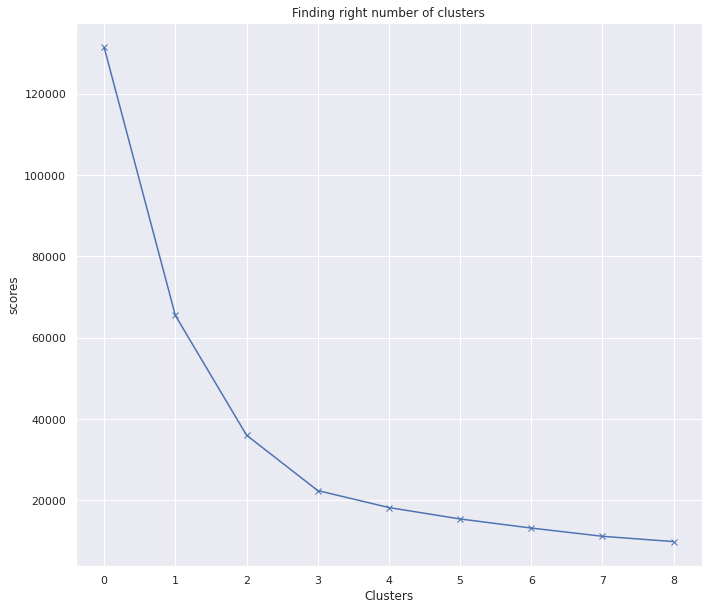

In [ ]:
# # plot the Elbow method
inertias_2 = []

range_values = range(1, 10)

for i in range_values:
  kmeans = KMeans(n_clusters= i)
  kmeans.fit(encoded_df)
  inertias_2.append(kmeans.inertia_)
plt.figure(figsize=(10,10))
plt.plot(inertias_2, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

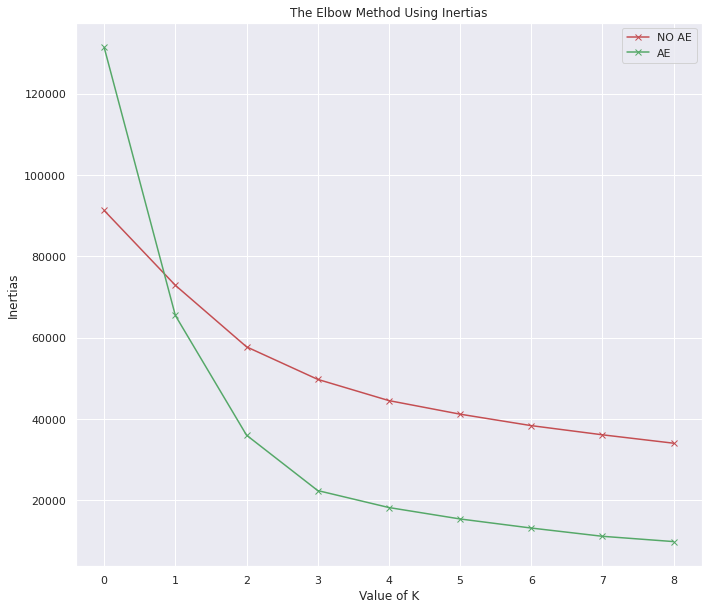

In [ ]:
# compare results 
plt.figure(figsize=(10,10))
plt.plot(inertias, 'bx-', color = 'r', label ='NO AE')
plt.plot(inertias_2, 'bx-', color = 'g', label ='AE')
plt.xlabel('Value of K')
plt.ylabel('Inertias')
plt.title('The Elbow Method Using Inertias')
plt.legend()
plt.show()

In [ ]:
# basedon the elbow method, choose 4 clusters
kmeans = KMeans(n_clusters=4)
kmeans.fit(encoded_df)
labels_ae = kmeans.labels_

In [ ]:
# get the autoencoder features
ae_df = pd.DataFrame(data = encoded_df, columns =['ae1','ae2','ae3'])
ae_df = pd.concat([ae_df,pd.DataFrame({'cluster_ae':labels_ae})], axis = 1)
ae_df.head()

,ae1,ae2,ae3,cluster_ae
0,1.149304,2.530718,0.963957,0
1,3.941448,3.843560,1.787421,3
2,0.934246,2.367853,0.755673,0
3,2.444294,1.432226,0.516907,0
4,4.117315,8.489957,4.899618,1


In [ ]:
# generate a 3d plot
import plotly.graph_objects as go

ClusterPlot = go.Figure() # We create the figure

for C in list(ae_df.cluster_ae.unique()): # We add the points according to its cluster
    
    ClusterPlot.add_trace(go.Scatter3d(x = ae_df[ae_df.cluster_ae == C]['ae1'], # We define the values for each variable
                                y = ae_df[ae_df.cluster_ae == C]['ae2'],
                                z = ae_df[ae_df.cluster_ae == C]['ae3'],
                                mode = 'markers', marker_size = 7, marker_line_width = 1,
                                name = 'Group ' + str(C)))
    
ClusterPlot.update_layout(width = 800, height = 800, autosize = True, showlegend = True, # We add some format to the table
                   scene = dict(xaxis=dict(title = 'ae1', titlefont_color = 'black'),
                                yaxis=dict(title = 'ae2', titlefont_color = 'black'),
                                zaxis=dict(title = 'ae3', titlefont_color = 'black')),
                   font = dict(family = "Gilroy", color  = 'black', size = 12))

ClusterPlot.show(renderer="colab")

In [ ]:
# have a look of the result
df_cluster_dr = pd.concat([df_x, pd.DataFrame({'cluster_ae':labels_ae})], axis = 1)
df_cluster_dr.head()

,age,time_from_last_activity,time_from_register,transaction_max,total_fee,total_payout,total_boost_payout,cum_BoostPayout,cum_Deposit,cum_Withdrawal,cluster,cluster_ae
0,19,2,171,26,57.0,187.0,0.0,0.0,0.0,0.0,3,0
1,61,1,85,6,14.0,0.0,0.0,0.0,0.0,0.0,1,3
2,26,1,186,41,70.0,10.0,0.0,0.0,60.0,0.0,3,0
3,32,3,3,3,20.0,0.0,0.0,0.0,200.0,0.0,1,0
4,29,6,7,25,200.0,105.0,0.0,0.0,200.0,105.0,0,1


## Cluster Analysis

In [ ]:
# Cluster analysis
cluster_analysis = df_cluster_dr.groupby(['cluster_ae'], as_index=False).mean()
cluster_analysis['Count'] = df_cluster_dr.groupby('cluster_ae').size()
cluster_analysis['%'] = cluster_analysis['Count']*100 / cluster_analysis['Count'].sum()
cluster_analysis

,cluster_ae,age,time_from_last_activity,time_from_register,transaction_max,total_fee,total_payout,total_boost_payout,cum_BoostPayout,cum_Deposit,cum_Withdrawal,cluster,Count,%
0,0,26.890970,3.917300,178.872613,15.533098,51.399221,9.217041,0.006675,0.001113,48.187465,0.004291,1.741331,5393,59.062534
1,1,30.854908,2.324324,148.735420,80.765292,350.486486,530.036984,1.955903,0.015647,152.731152,297.107312,0.130868,703,7.699047
2,2,28.466019,2.524272,252.815534,65.281553,235.135922,308.786408,60.815534,53.679612,60.796117,88.581165,1.980583,103,1.128025
3,3,40.104707,2.783765,144.535812,44.418827,152.812756,133.360334,0.063097,0.002046,58.027967,1.317040,2.224761,2932,32.110393


In [ ]:
# rename clusters
cluster_analysis.rename(index={
    0: 'Inactive User',
    1: 'Skilled User',
    2: 'Bonus User',
    3: 'Regular User'
}, inplace=True)
cluster_analysis

,cluster_ae,age,time_from_last_activity,time_from_register,transaction_max,total_fee,total_payout,total_boost_payout,cum_BoostPayout,cum_Deposit,cum_Withdrawal,cluster,Count,%
Inactive User,0,26.890970,3.917300,178.872613,15.533098,51.399221,9.217041,0.006675,0.001113,48.187465,0.004291,1.741331,5393,59.062534
Skilled User,1,30.854908,2.324324,148.735420,80.765292,350.486486,530.036984,1.955903,0.015647,152.731152,297.107312,0.130868,703,7.699047
Bonus User,2,28.466019,2.524272,252.815534,65.281553,235.135922,308.786408,60.815534,53.679612,60.796117,88.581165,1.980583,103,1.128025
Regular User,3,40.104707,2.783765,144.535812,44.418827,152.812756,133.360334,0.063097,0.002046,58.027967,1.317040,2.224761,2932,32.110393


In [ ]:
# Label the clusters based on cluster analysis
df_cluster_dr['Label'] = df_cluster_dr['cluster_ae'].map({0: 'Inactive User', 1: 'Skilled User', 2: 'Bonus User', 3: 'Regular User'})
df_cluster_dr.head()

,age,time_from_last_activity,time_from_register,transaction_max,total_fee,total_payout,total_boost_payout,cum_BoostPayout,cum_Deposit,cum_Withdrawal,cluster,cluster_ae,Label
0,19,2,171,26,57.0,187.0,0.0,0.0,0.0,0.0,3,0,Inactive User
1,61,1,85,6,14.0,0.0,0.0,0.0,0.0,0.0,1,3,Regular User
2,26,1,186,41,70.0,10.0,0.0,0.0,60.0,0.0,3,0,Inactive User
3,32,3,3,3,20.0,0.0,0.0,0.0,200.0,0.0,1,0,Inactive User
4,29,6,7,25,200.0,105.0,0.0,0.0,200.0,105.0,0,1,Skilled User


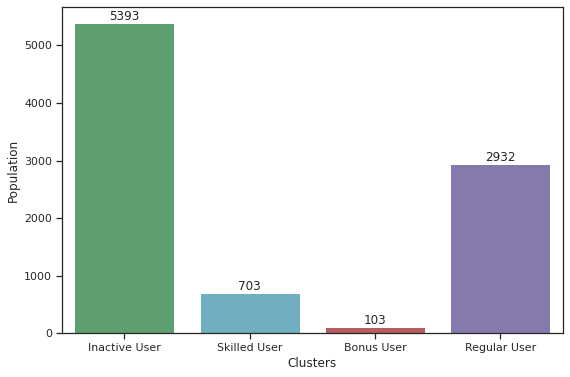

In [ ]:
# visualize clusters result
plt.figure(figsize=(8, 6))
s = sns.barplot(data=cluster_analysis, x=cluster_analysis.index, y='Count', palette=['g','c','r','m'])
plt.bar_label(s.containers[0])
plt.xlabel('Clusters')
plt.ylabel('Population')
plt.show()

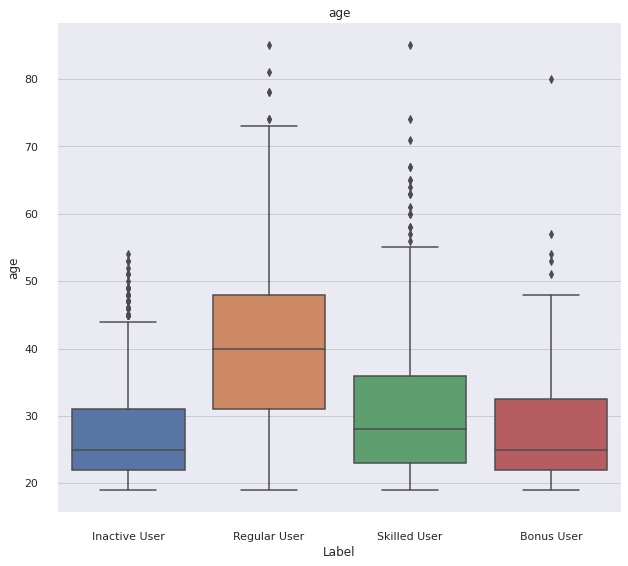

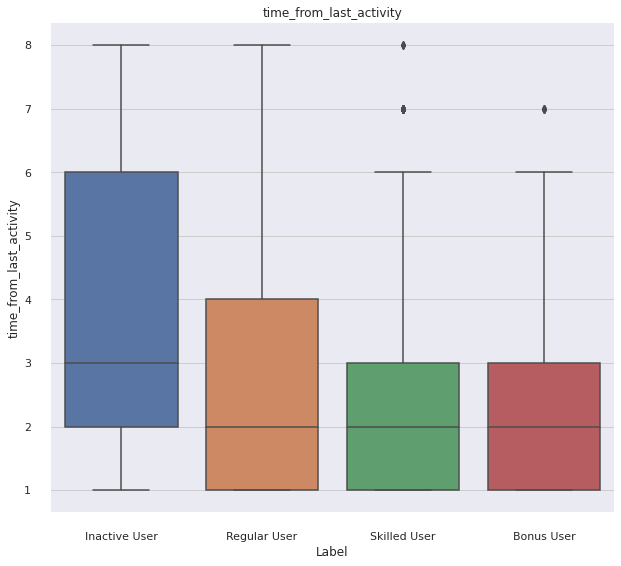

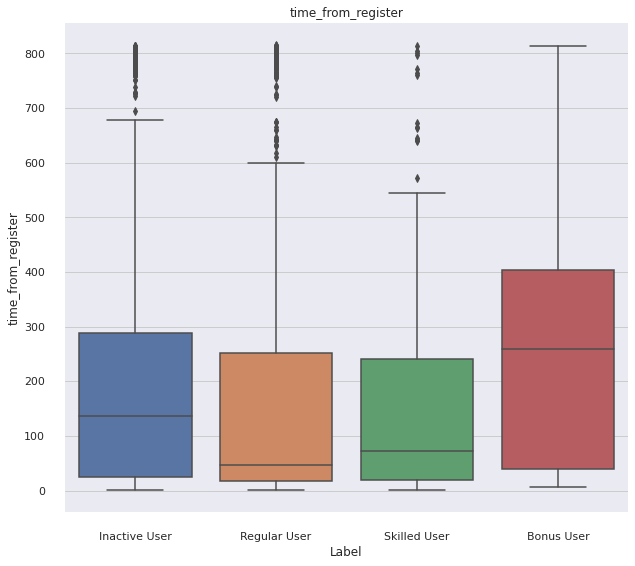

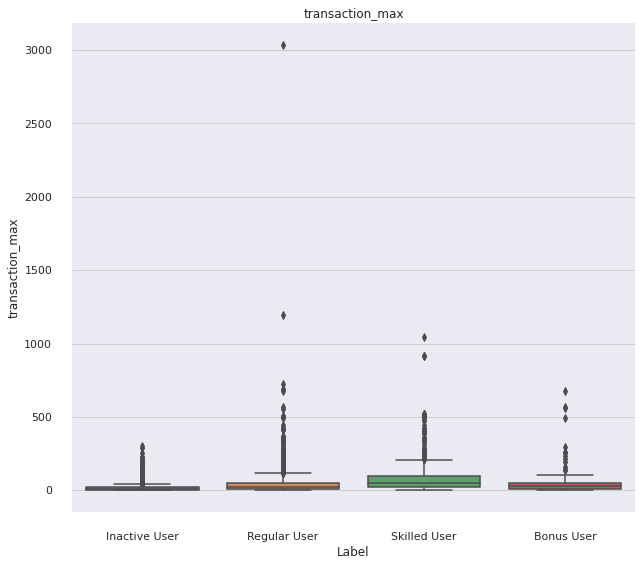

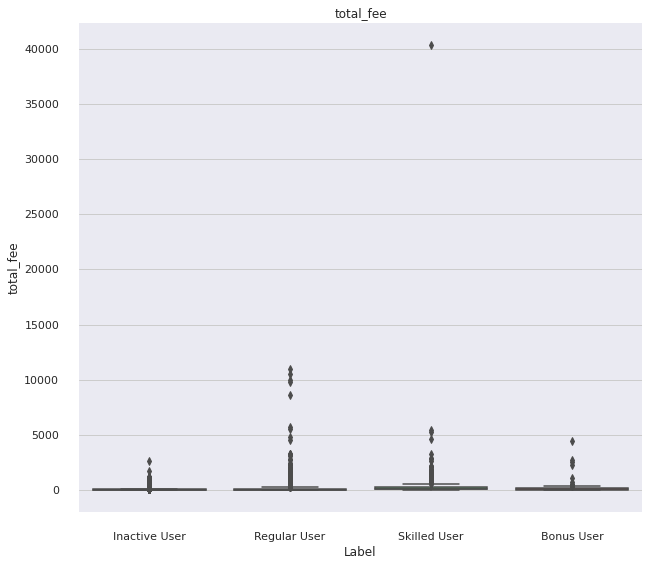

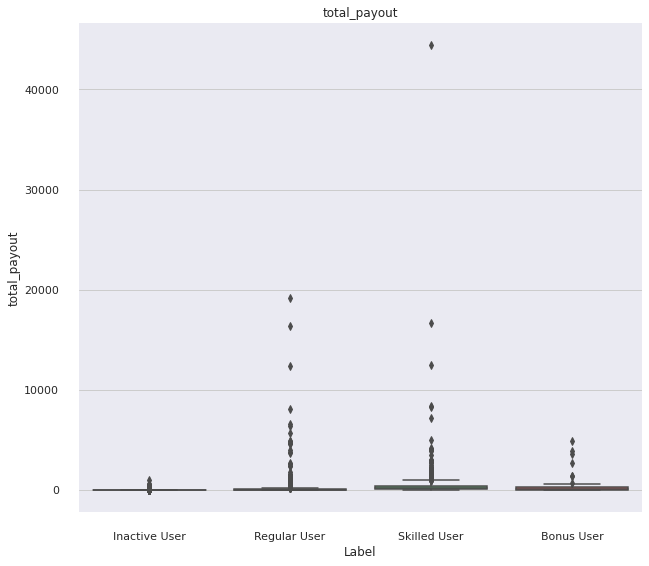

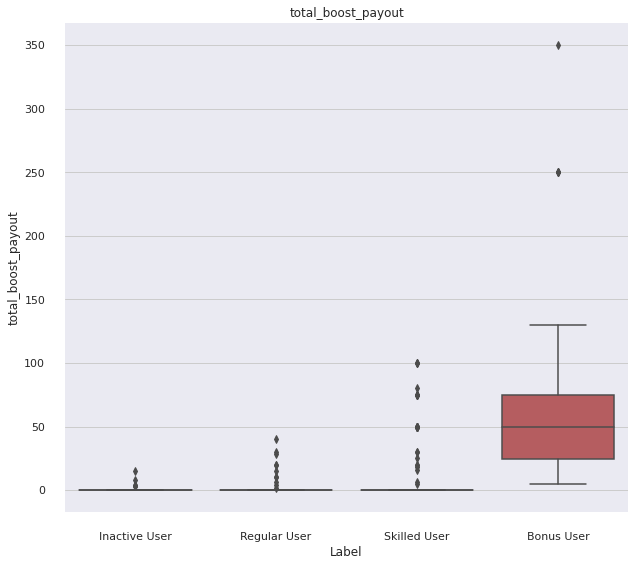

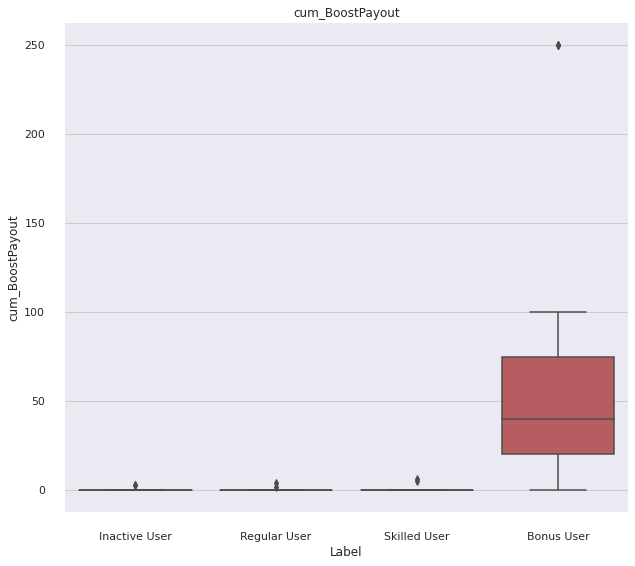

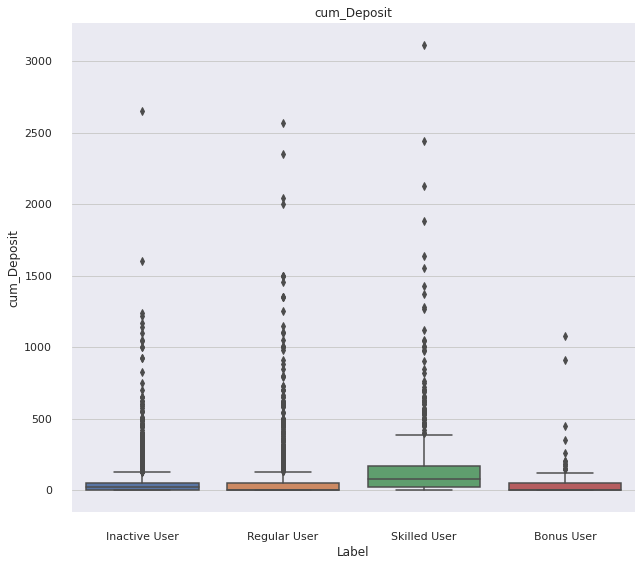

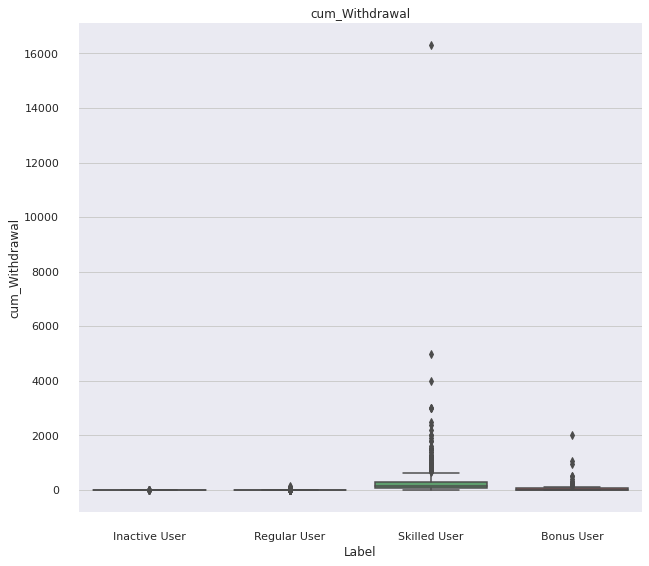

In [ ]:
# plot boxplot for each feature
for column in df_cluster_dr.columns[:-3]:  # Loop over all columns
    sns.set()
    fig, ax = plt.subplots()
    sns.set(style="ticks")
    sns.boxplot(x='Label', y=column, data=df_cluster_dr)  
    sns.despine(offset=10, trim=True) 
    fig.set_size_inches(9,9)
    plt.savefig('{}.pdf'.format(column), bbox_inches='tight') 
    plt.title(column)

In [ ]:
# Cluster Analysis visulazation 
cluster_analysis_2 = cluster_analysis[['age', 'time_from_last_activity', 'time_from_register',
       'transaction_max', 'total_fee', 'total_payout', 'total_boost_payout']]

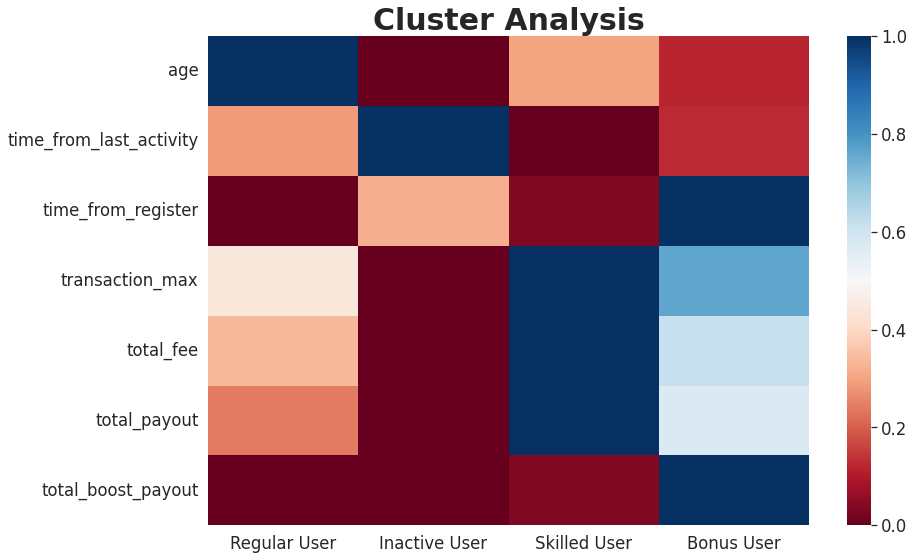

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler2 = MinMaxScaler()
scaler2.fit(cluster_analysis_2)
df_segm_pca_analysis_plot = pd.DataFrame(scaler2.transform(cluster_analysis_2), columns = ['age', 'time_from_last_activity', 'time_from_register',
       'transaction_max', 'total_fee', 'total_payout', 'total_boost_payout'])
df_segm_pca_analysis_plot.rename(index={
    0: 'Inactive User',
    1: 'Skilled User',
    2: 'Bonus User',
    3: 'Regular User'
}, inplace=True)
df_segm_pca_analysis_plot = df_segm_pca_analysis_plot.loc[['Regular User','Inactive User','Skilled User','Bonus User']]


heatcmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(12, 9))
s = sns.heatmap(
    df_segm_pca_analysis_plot.T,
    vmin=0,
    vmax=1,
    cmap='RdBu',
)
sns.set(font_scale=2.5)
plt.title('Cluster Analysis',fontweight='bold')
plt.show()